In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 292.8/292.8 kB 6.0 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from empiricaldist import Cdf
from statistics import mean

In [5]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [6]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [9]:
from utils import decorate, savefig
# make a directory for figures
#!mkdir -p figs

In [10]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [11]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [12]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [13]:
from Cell2D import Cell2D, draw_array
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        #tracking steps
        self.counter = 0
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
        #tax money
        self.taxmoney = 0

        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        #tax setback
        self.taxmoney = 0
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            #add taxation
            self.taxmoney += agent.paid
            
            # execute one step
            agent.step(self, self.taxmoney, self.agents)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)
                
            
            
            
        #set counter
        self.counter += 1

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        
        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys
    
    def get_tax(self):
        return self.taxmoney
    
    def get_agents(self):
        agents = 0
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            agents += 1
        return agents
            
        

In [14]:
class Agent:

    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        vision = params.get('vision', 3)
        metabolism = params.get('metabolism', 2)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        tax = params.get('tax', 0.5)
        tax_threshold = params.get('tax_threshold', 40)
        
        # choose attributes
        self.vision = abs(round(np.random.normal(vision, vision/2)))+1
        #self.metabolism = np.random.uniform(1, max_metabolism)
        #self.vision = round(np.random.normal(4, 1))#.round().astype(int)
        self.metabolism = abs(np.random.normal(metabolism, metabolism/2))
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        mean_wealth = (min_sugar + max_sugar)/2
        self.sugar = abs(round(np.random.normal(mean_wealth, mean_wealth/2)))# np.random.uniform(min_sugar, max_sugar)
        self.tax = tax
        self.paid = 0
        self.tax_threshold = tax_threshold
        

    def step(self, env, taxpay, agents_n):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.paid = 0
        self.loc = env.look_and_move(self.loc, self.vision)
        
        if self.sugar > self.tax_threshold:
            self.sugar = self.sugar + env.harvest(self.loc) + (taxpay/len(agents_n)) - self.metabolism - (self.sugar*self.tax) 
            self.paid += (self.sugar*self.tax)
            
        else:
            self.sugar = self.sugar + env.harvest(self.loc) + (taxpay/len(agents_n)) - self.metabolism
        
        
        self.age += 1
        #env.get_agents()
        
                         

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan
   
        

In [15]:
class EvoSugarscape(Sugarscape):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        Sugarscape.__init__(self, n, **params)
        
        # track variables
        self.avg_vision_seq = []
        self.avg_metabolism_seq = []
        self.tax_seq = []
        self.fed_budget_seq = []
        self.counter_seq = []
        self.wealth = []
        
    
    def step(self):
        """Executes one time step."""
        Sugarscape.step(self)
        
        # average vision
        avg_vision = np.mean([agent.vision for agent in self.agents])
        self.avg_vision_seq.append(avg_vision)
        
        # average metabolism
        avg_metabolism = np.mean([agent.metabolism for agent in self.agents])
        self.avg_metabolism_seq.append(avg_metabolism)
        
        #testing, irrelevant
        tax = np.sum([agent.paid for agent in self.agents])
        self.tax_seq.append(tax)
        
        #tax overview
        fed_budget = self.taxmoney
        self.fed_budget_seq.append(fed_budget)
        
        #gini prepare
        
        
        
        # add an agent
        add_agents = self.params.get('add_agents', False)
        if add_agents:
            self.add_agent()
        
        return len(self.agents)
    
    
    
    def gini_output(self):
        
        def gini(x):
            total = 0
            for i, xi in enumerate(x[:-1], 1):
                total += np.sum(np.abs(xi - x[i:]))
            return total / (len(x)**2 * np.mean(x))
        
        for agent in self.agents:
            self.wealth.append(agent.sugar)
        return gini(self.wealth)
        
        

In [43]:
np.random.seed(41)

env = EvoSugarscape(50, 
                 num_agents=100,
                 min_lifespan=60, 
                 max_lifespan=90,
                 min_sugar = 5,
                 max_sugar = 25,
                 grow_rate = 1,
                 metabolism = 8,
                 vision = 6,
                 tax = 0.1,
                 tax_threshold = 0,
                 add_agents=True,
                 replace=False)

env.loop(200)

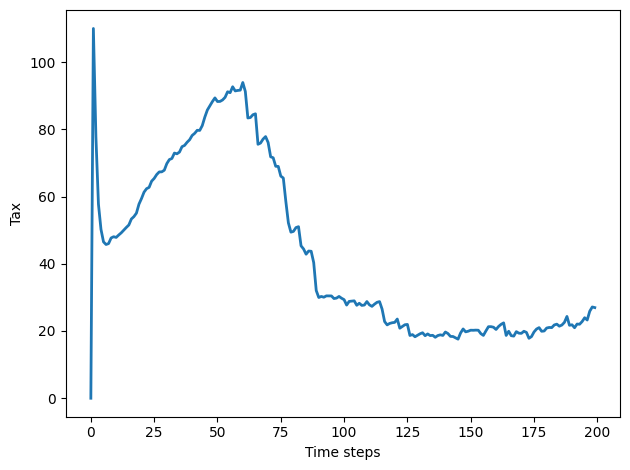

In [44]:
plt.plot(env.fed_budget_seq)
decorate(xlabel='Time steps', ylabel='Tax')
#print (sum(env.fed_budget_seq)/len(env.fed_budget_seq))

In [45]:
env.gini_output()

0.35207134289751246

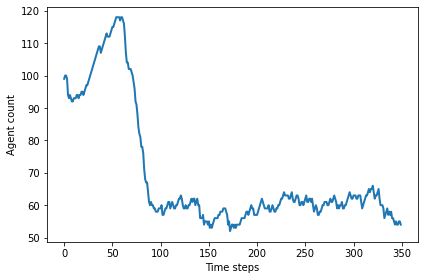

In [84]:
plt.plot(env.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Agent count')

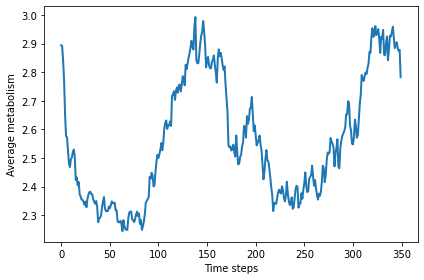

In [85]:
plt.plot(env.avg_metabolism_seq)
decorate(xlabel='Time steps', ylabel='Average metabolism')

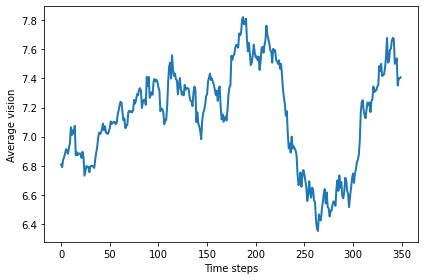

In [86]:
plt.plot(env.avg_vision_seq)
decorate(xlabel='Time steps', ylabel='Average vision')

array([ 20.93017147,  35.63470163,  95.36778901, 135.88224065,
       228.1314697 ])

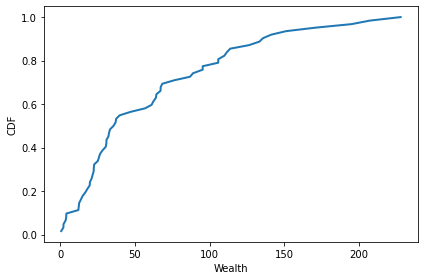

In [90]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Wealth', ylabel='CDF')

cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.999])

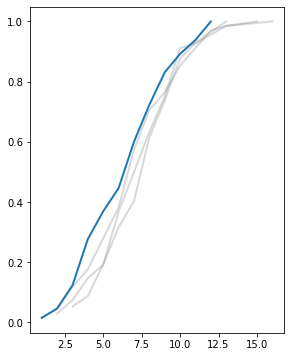

In [107]:
cdf = Cdf.from_seq(agent.vision for agent in env.agents)
cdfs = [cdf]
for i in range(3):
    env.loop(100)
    cdf = Cdf.from_seq(agent.vision for agent in env.agents)
    cdfs.append(cdf)
    
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Vision', ylabel='CDF')

#plt.subplot(1, 2, 2)
#plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
#plot_cdfs(cdfs[-1:], color='C0')
#decorate(xlabel='Vision', ylabel='CDF', xscale='log')

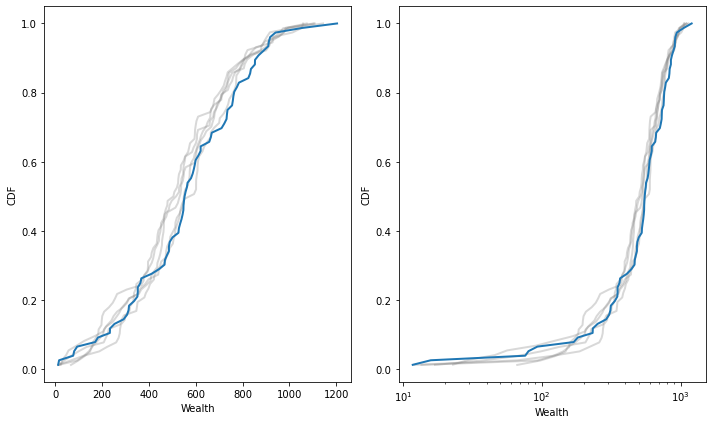

In [224]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]
for i in range(5):
    env.loop(100)
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    cdfs.append(cdf)
    
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF')

plt.subplot(1, 2, 2)
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF', xscale='log')

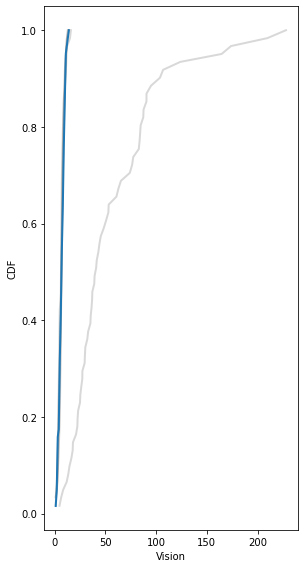

In [111]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]

gini_notax = []
df_notax = pd.DataFrame(columns=['0.25', '0.50', '0.75', '0.90', '0.99'])
for i in np.linspace(250, 350, num=5).astype(int):
    env = EvoSugarscape(50, 
                 num_agents=100,
                 min_lifespan=60, 
                 max_lifespan=90,
                 min_sugar = 5,
                 max_sugar = 25,
                 grow_rate = 1,
                 metabolism = 3,
                 vision = 6,
                 tax = 0,
                 tax_threshold = 0,
                 add_agents=True,
                 replace=False)
    
    env.loop(i)
    
    cdf = Cdf.from_seq(agent.vision for agent in env.agents)
    cdfs.append(cdf)
    
    gini_notax.append(env.gini_output())
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    df_notax.loc[len(df_notax)] = cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.99]).tolist()
    

    

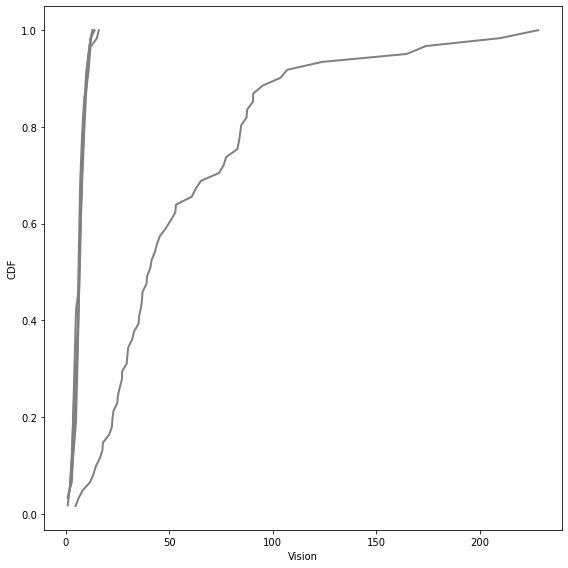

In [113]:
plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray')
#plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Sugar', ylabel='CDF')

In [93]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]

gini_alltax = []
df_alltax = pd.DataFrame(columns=['0.25', '0.50', '0.75', '0.90', '0.99'])
for i in np.linspace(250, 350, num=5).astype(int):
    env = EvoSugarscape(50, 
                 num_agents=100,
                 min_lifespan=60, 
                 max_lifespan=90,
                 min_sugar = 5,
                 max_sugar = 25,
                 grow_rate = 1,
                 metabolism = 3,
                 vision = 6,
                 tax = 0.42,
                 tax_threshold = 0,
                 add_agents=True,
                 replace=False)
    
    env.loop(i)
    
    cdf = Cdf.from_seq(agent.vision for agent in env.agents)
    cdfs.append(cdf)
    
    gini_alltax.append(env.gini_output())
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    df_alltax.loc[len(df_alltax)] = cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.99]).tolist()
    
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Vision', ylabel='CDF')


df_notax.mean(axis=0)
df_notax
mean(gini_notax)

,0.25,0.50,0.75,0.90,0.99
0,5.490653,7.158460,9.707755,10.676663,14.242239
1,5.192768,6.505930,8.172623,9.926670,15.000000
2,4.082665,5.970838,8.002559,10.773186,22.000000
3,4.838971,6.538032,9.003599,11.006061,12.130738
4,3.404116,5.904532,8.148297,11.202054,14.495167


In [94]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]

gini_richtax = []
df_richtax = pd.DataFrame(columns=['0.25', '0.50', '0.75', '0.90', '0.99'])
for i in np.linspace(250, 350, num=5).astype(int):
    env = EvoSugarscape(50, 
                 num_agents=100,
                 min_lifespan=60, 
                 max_lifespan=90,
                 min_sugar = 5,
                 max_sugar = 25,
                 grow_rate = 1,
                 metabolism = 3,
                 vision = 6,
                 tax = 0.55,
                 tax_threshold = 20,
                 add_agents=True,
                 replace=False)
    
    env.loop(i)
    
    cdf = Cdf.from_seq(agent.vision for agent in env.agents)
    cdfs.append(cdf)
    
    gini_richtax.append(env.gini_output())
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    df_richtax.loc[len(df_richtax)] = cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.99]).tolist()
    
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Vision', ylabel='CDF')


df_alltax.mean(axis=0)
mean(gini_alltax)

,0.25,0.50,0.75,0.90,0.99
0,12.464917,14.789267,18.662829,20.462158,23.750807
1,11.670825,14.765394,18.194400,19.881957,22.068224
2,11.355535,13.906016,18.337814,19.911664,23.165627
3,12.115763,14.931458,18.528195,20.222940,31.000000
4,11.428360,14.723629,18.743823,21.255103,22.925502


In [97]:
df_richtax.mean(axis=0)
mean(gini_richtax)
env.gini_output()

0.25    11.807080
0.50    14.623153
0.75    18.493412
0.90    20.346765
0.99    24.582032
dtype: float64